In [135]:
import os
import sys
import pickle
import pathlib
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cycler import cycler
import numpy as np
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from TVRegDiff import TVRegDiff
from mpl_settings_v3 import *
from auxiliary import get_base_network_name

%matplotlib inline
    
meank = 5

fig_dir = '../draft/figs'
net_dir_name = '../networks/ER/ER_k{:.2f}'.format(meank)


attack_dict = {'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
               'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$'}

N_values_dict = {
    'Ran': [4000, 6000, 8000, 16000, 32000, 64000], 
    'Deg': [4000, 6000, 8000, 12000, 16000, 32000, 64000], 
    'DegU': [4000, 6000, 8000, 12000, 16000, 32000, 64000],
    'Btw': [4000, 6000, 8000, 12000, 16000, 32000],
    'BtwU': [1000, 2000, 3000, 4000, 8000]
}

#fminmax_values = {'Ran': (0.7, 0.85), 'Deg': (0.35, 0.5), 'DegU': (0.3, 0.4),
#               'Btw': (0.45, 0.65), 'BtwU': (0.2, 0.33)}

fminmax_values = {'Ran': (0.72, 0.87), 'Deg': (0.4, 0.55), 'DegU': (0.315, 0.38),
               'Btw': (0.4, 0.65), 'BtwU': (0.26, 0.32)}

attacks = ['Ran', 'Deg', 'DegU', 'Btw', 'BtwU']

In [140]:
def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

def load_dfs(attack, N_values, meank):

    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    dfs50000 = {}
    for N in N_values:
        dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        try:
            dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        except:
            pass
        try:
            dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)
        except:
            pass
        try:
            dfs50000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=50000)
        except:
            pass

    dfsMax = {}
    for N in N_values:
        if N in dfs50000:
            dfsMax[N] = dfs50000[N]
        elif N in dfs20000:
            dfsMax[N] = dfs20000[N]
        elif N in dfs10000:
            dfsMax[N] = dfs10000[N]
        else:
            dfsMax[N] = dfs1000[N]
            
    return dfs1000, dfs10000, dfs20000, dfsMax

def get_deriv_log(dfs, N, measure, fmin, fmax, overwrite=False, **kwargs):

    f = dfs[N].f.values[int(N*fmin):int(N*fmax)]
    dx = f[1] - f[0]
    values = dfs[N][measure].values[int(N*fmin):int(N*fmax)]
    if 'Ngcc':
        values = values / N
    testf = np.log(values)
    deriv_lrg = TVRegDiff(testf, **kwargs, dx=dx)
    deriv_lrg_np = np.gradient(testf, dx)
    return np.array([f, deriv_lrg, deriv_lrg_np])

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

def five_point_der(X):
    X = np.array(X)
    n = X.shape[0]
    dX = np.zeros(n)
    dX[0] = np.NaN
    dX[1] = np.NaN
    dX[-2] = np.NaN
    dX[-1] = np.NaN
    
    for i, x in enumerate(X):
        if (i < 2) or (i > (n-3)):
            continue
        dX[i] = n*(X[i-2] - 8*X[i-1] + 8*X[i+1] - X[i+2])/12
    
    return dX

In [148]:
overwrite = False

derivs_attack = {}
derivs5_attack = {}
for attack in attacks:
    fmin, fmax = fminmax_values[attack]
    N_values = N_values_dict[attack]
    print(attack, N_values)

    _, _, _, dfs = load_dfs(attack, N_values, meank)
    
    derivs5 = {}
    for N in N_values:
        deriv5 = five_point_der(np.log(dfs[N].Sgcc.values))
        derivs5[N] = deriv5[int(fmin*N):int(fmax*N)]
    derivs5_attack[attack] = derivs5

    
    measure = 'Sgcc'
    args = dict(itern=200, alph=5e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0)   

    derivs_dict = {}
    for N in N_values:
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        print(network)
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], 
                                                                                             args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)
        if os.path.isfile(data_file) and not overwrite:
            print('Reading previous data')
            derivs = np.loadtxt(data_file)
        else:
            derivs = get_deriv_log(dfs, N, measure, fmin, fmax, **args)
            np.savetxt(data_file, derivs)
        derivs_dict[N] = derivs
    derivs_attack[attack] = derivs_dict


Ran [4000, 6000, 8000, 16000, 32000, 64000]
ER_k5.00_N4000
Reading previous data
ER_k5.00_N6000
Reading previous data
ER_k5.00_N8000
Reading previous data
ER_k5.00_N16000
Reading previous data
ER_k5.00_N32000
Reading previous data
ER_k5.00_N64000
Reading previous data
Deg [4000, 6000, 8000, 12000, 16000, 32000, 64000]
ER_k5.00_N4000
Reading previous data
ER_k5.00_N6000
Reading previous data
ER_k5.00_N8000
Reading previous data
ER_k5.00_N12000
Reading previous data
ER_k5.00_N16000
Reading previous data
ER_k5.00_N32000
Reading previous data
ER_k5.00_N64000
Reading previous data
DegU [4000, 6000, 8000, 12000, 16000, 32000, 64000]
ER_k5.00_N4000
Reading previous data
ER_k5.00_N6000
Reading previous data
ER_k5.00_N8000
Reading previous data
ER_k5.00_N12000
Reading previous data
ER_k5.00_N16000
Reading previous data
ER_k5.00_N32000
Reading previous data
ER_k5.00_N64000
Reading previous data
Btw [4000, 6000, 8000, 12000, 16000, 32000]
ER_k5.00_N4000
Reading previous data
ER_k5.00_N6000
Readin

Ran


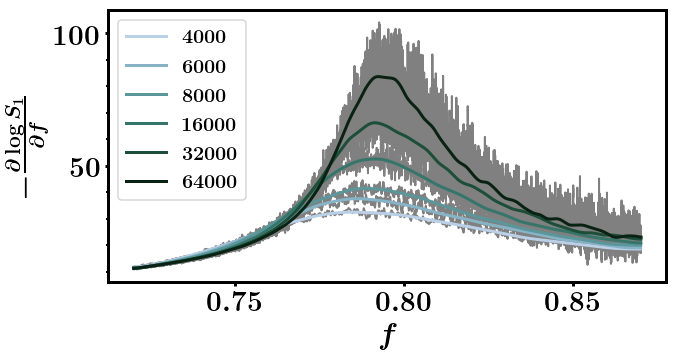

Deg


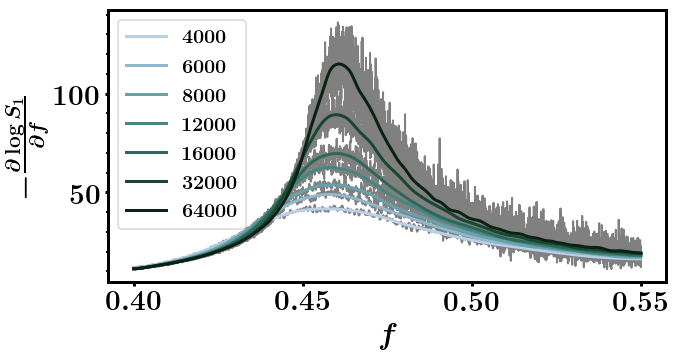

DegU


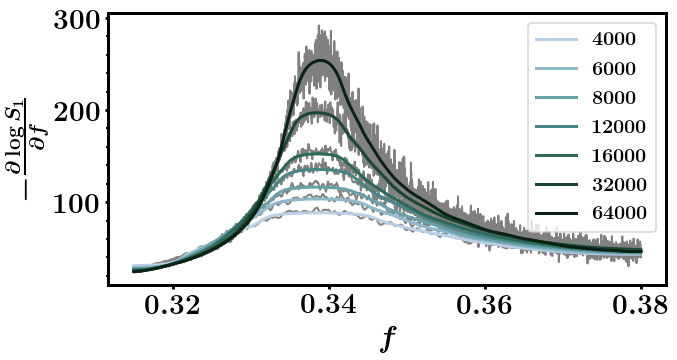

Btw


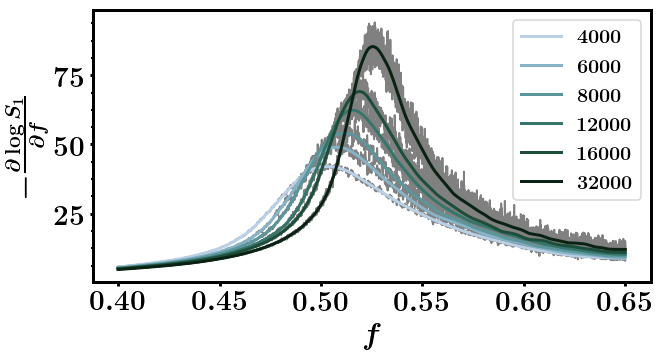

BtwU


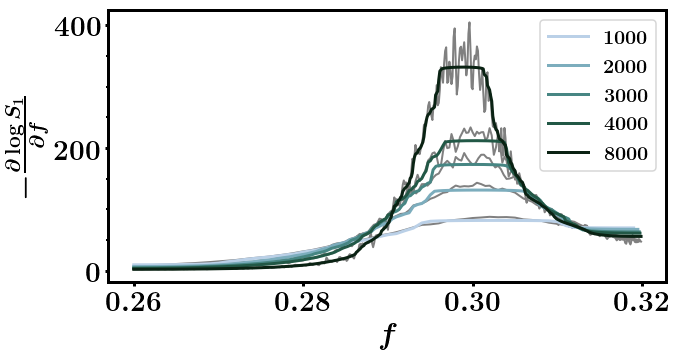

In [153]:
for attack in attacks:
#for attack in ['BtwU']:
    print(attack)
    derivs_dict = derivs_attack[attack]
    N_values = N_values_dict[attack]
    
    colors = sns.cubehelix_palette(len(N_values), start=2, rot=0.3, light=0.8, dark=0.1)
    fig, ax = plt.subplots(figsize=(10, 5), ncols=1, nrows=1)
    
    for i, N in enumerate(N_values):
        f, deriv, deriv_np = derivs_dict[N]
        deriv5 = derivs5_attack[attack][N]
        #ax.plot(f, -deriv5, color='black', linewidth=2)
        ax.plot(f, -deriv_np, color='grey', linewidth=2)
        
        
    for i, N in enumerate(N_values):
        f, deriv, deriv_np = derivs_dict[N]
        ax.plot(f, -deriv, label=r'${{{}}}$'.format(N), color=colors[i])
    ax.set_xlabel(r'$f$')
    ax.set_ylabel(r'$-\frac{\partial \log S_1}{\partial f}$')
    ax.legend(loc='best', fontsize=20)
    base_fig_name = 'dlogS1df_{}'.format(attack)
    full_fig_name = os.path.join(fig_dir, base_fig_name)
    #plt.savefig(full_fig_name + '.png')
    #plt.savefig(full_fig_name + '.pdf')
    plt.show()
    plt.show()

Ran	0.339 +- 0.005
	2.946 +- 0.043
Ran	0.327 +- 0.008
	3.054 +- 0.077


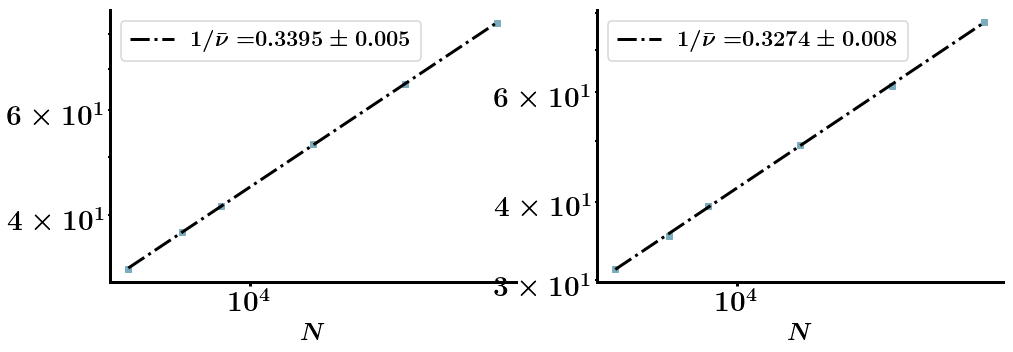

Deg	0.365 +- 0.006
	2.741 +- 0.047
Deg	0.347 +- 0.010
	2.880 +- 0.086


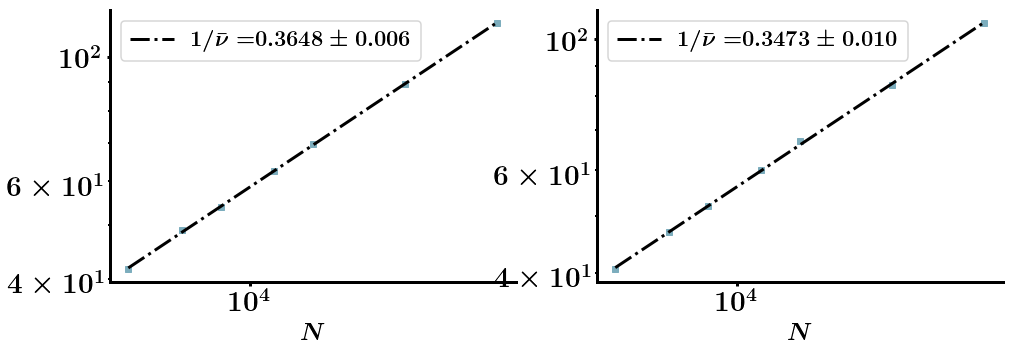

DegU	0.381 +- 0.009
	2.624 +- 0.062
DegU	0.380 +- 0.009
	2.633 +- 0.060


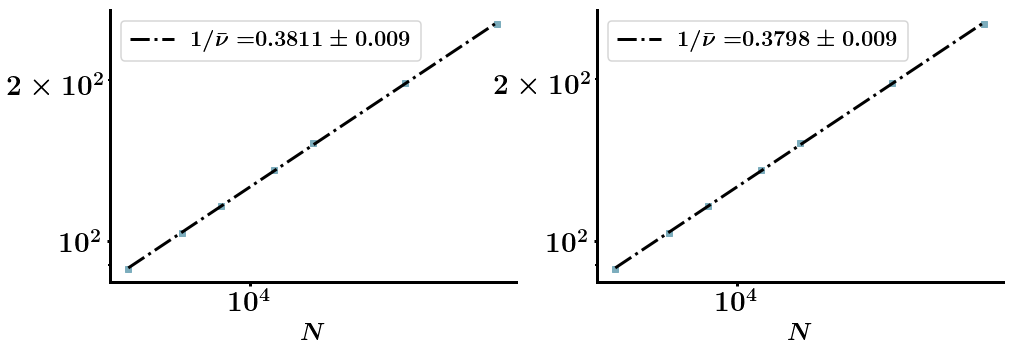

Btw	0.341 +- 0.022
	2.931 +- 0.187
Btw	0.288 +- 0.031
	3.467 +- 0.373


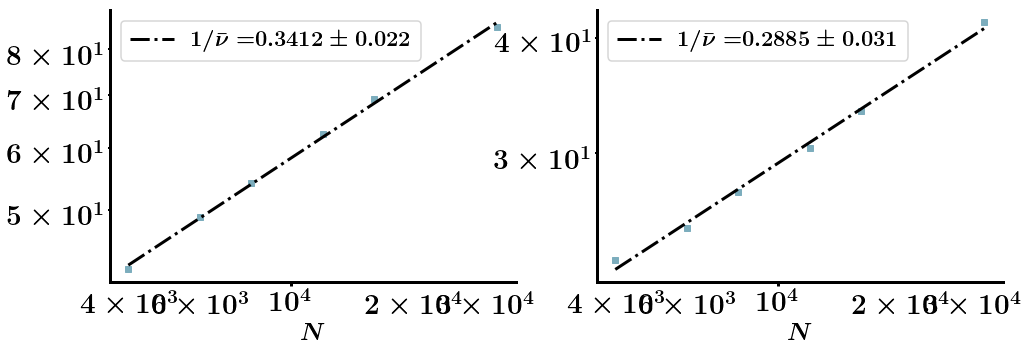

BtwU	0.675 +- 0.016
	1.482 +- 0.036
BtwU	0.672 +- 0.020
	1.489 +- 0.044


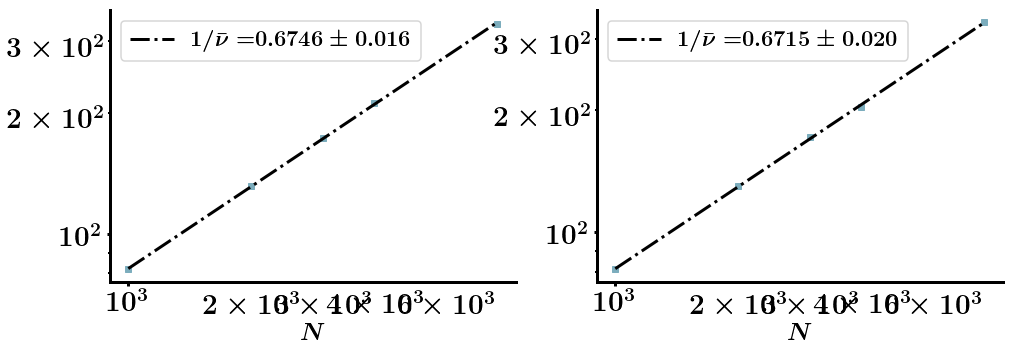

In [139]:
fc_values = {
    'Ran': 0.8,
    'Deg':  0.4653,
    'DegU': 0.3395,
    'Btw':  0.555,
    'BtwU': 0.2965
}

for attack in attacks:

    crit_values = []
    max_values = []
    derivs_dict = derivs_attack[attack]
    N_values = N_values_dict[attack]
    
    fc = fc_values[attack]
    fmin, fmax = fminmax_values[attack]
    
    for N in N_values:
        t, deriv, deriv_np = derivs_dict[N]
        max_pos = np.argmin(deriv)
        max_value = -np.min(deriv)
        max_values.append(max_value)
        crit = -deriv[int(fc*N)-int(N*fmin)]
        crit_values.append(crit)

    max_values = np.array(max_values)
    crit_values = np.array(crit_values)
    
    
    fig, axes = plt.subplots(figsize=(16, 5), ncols=2)
    
    for i, ax in enumerate(axes):
        ax.set_xscale('log')
        ax.set_yscale('log')
    
        if i == 0:
            y_values = max_values
        else:
            y_values = crit_values
            
        ax.plot(N_values, y_values, 's', color=colors[1])

        Y_pred, slope, err_slope = getLinearReg(N_values, y_values, return_r2=False)

        inverse_err = (1/slope**2) * (err_slope)
        print('{}\t{:.3f} +- {:.3f}'.format(attack, slope, err_slope))
        print('\t{:.3f} +- {:.3f}'.format(1/slope, inverse_err))
        label = r'$1/\bar{\nu} = $' + r'${{{:.4}}}\pm {{{:.3f}}}$'.format(slope, err_slope)
        ax.plot(N_values, Y_pred, '-.', color='k', label=label)    
        ax.legend(loc='best', fontsize=22)
        ax.set_xlabel(r'$N$', fontsize=24)
    
    sns.despine()
    #ax.set_xlabel(r'$\frac{d\log (S_1)}{df}$', fontsize=28)
    #plt.savefig('../figs/dlogS1df_scaling_{}.png'.format(attack))
    #plt.savefig('../figs/dlogS1df_scaling_{}.pdf'.format(attack))
    plt.show()

In [34]:
fc_dict = get_fc_dict()
for attack in attacks:
    
    crit_values = []
    derivs_dict = derivs_attack[attack]
    N_values = N_values_dict[attack]
    p_values = [meank/N for N in N_values]
    dfs = load_dataframes(attack, N_values, p_values)
    fmin, fmax = fminmax_values[attack]
    #mean_fc, std_fc = compute_fc_v2(dfs, N_values, fmin, fmax)
    mean_fc, std_fc = fc_dict[attack]
    print(attack, N_values, '{:.4f}+/-{:.4f}'.format(mean_fc, std_fc))
    for N in N_values:
        t, deriv, deriv_np = derivs_dict[N]
        crit = [-deriv[int(fc*N)-int(N*fmin)] for fc in [mean_fc-std_fc, mean_fc, mean_fc+std_fc]]
        crit_values.append(crit)
    crit_values = np.array(crit_values)
    
    _, min_slope, _ = getLinearReg(N_values, crit_values[:,0], return_r2=True)
    Y_pred, slope, r2 = getLinearReg(N_values, crit_values[:,1], return_r2=True)
    _, max_slope, _ = getLinearReg(N_values, crit_values[:,2], return_r2=True)
    err_slope = np.max([np.abs(max_slope - slope), np.abs(min_slope - slope)])

    fig, ax = plt.subplots(figsize=(9, 5))
    inverse_err = (1/slope**2) * (err_slope)
    #label = r'$1/\bar{ \nu }$' + r'$ = {{{:.3}}}\pm {{{:.3f}}},\;\\ R^2 =  {{{:.5f}}} $'.format(slope, err_slope, r2)
    label = r'$\bar{ \nu }$' + r'$ = {{{:.3}}}\pm {{{:.3f}}},\;\\ R^2 =  {{{:.5f}}} $'.format(1/slope, inverse_err, r2)
    ax.plot(N_values, crit_values[:,1], 'o', markersize=8)
    ax.plot(N_values, Y_pred, '--', color='k', label=label)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r'$N$', fontsize=24)
    ax.set_xlabel(r'$-\frac{\partial \log (S_{1c})}{\partial f}$', fontsize=28)
    ax.legend(loc='best', fontsize=20)
    base_fig_name = 'dlogS1df_scaling_{}'.format(attack)
    full_fig_name = os.path.join(fig_dir, base_fig_name)
    plt.savefig(full_fig_name + '.png')
    plt.savefig(full_fig_name + '.pdf')
    plt.show()
    
    print(1/slope, inverse_err)

NameError: name 'get_fc_dict' is not defined